# Imported Libraries

In [ ]:
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import mnist
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import numpy as np
import torch

# Build a Model for the MNIST Dataset

## Step 1: Loading and Preprocessing the MNIST Dataset

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]
num_features = np.prod(input_shape)

# Normalize pixel values to the range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

def encode_to_one_hot(labels):
    one_hot = np.zeros((labels.shape[0], 10))
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_train = encode_to_one_hot(y_train)
y_test = encode_to_one_hot(y_test)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, num_features).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).reshape(-1, num_features).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

## Step 2: Building and Optimizing Your Model for MNIST

In [ ]:
def train(model, x_train, y_train, batch_size, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for i in range(0, len(x_train), batch_size):
        inputs = x_train[i:i+batch_size].view(-1, num_features).to(device)
        targets = y_train[i:i+batch_size].to(device)

        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(targets, dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == torch.argmax(targets, dim=1)).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / (len(x_train) // batch_size)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def test(model, x_test, y_test, batch_size, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for i in range(0, len(x_test), batch_size):
            x_batch = x_test[i:i+batch_size].to(device)
            y_batch = torch.argmax(y_test[i:i+batch_size].to(device), dim=1)

            x_batch = x_batch.view(-1, num_features).to(device)

            output = model(x_batch)
            pred = torch.argmax(output, dim=1)
            correct += (pred == y_batch).sum().item()
    return correct / len(x_test)

In [ ]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output_size, dropout_prob=0.2):
        super(MyModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.Dropout(p=dropout_prob),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.Dropout(p=dropout_prob),
            nn.ReLU(),
            nn.Linear(hidden2, output_size)
        )

    def forward(self, x):
      return self.layers(x)

In [ ]:
# Choose the hyperparameter search algorithm, define the hyperparameter search space, and tune the model.
hidden1_values = [256, 512]
hidden2_values = [128, 256]
dropout_values = [0.1, 0.2, 0.3]
learning_rates = [0.01, 0.001]
optimizers = ['Adam', 'Adagrad', 'RMSprop']
batch_size = 64
epochs = 5
best_accuracy = 0
best_params = {}

for hidden1 in hidden1_values:
  for hidden2 in hidden2_values:
    for dropout in dropout_values:
      for lr in learning_rates:
        for opt_name in optimizers:
          model = MyModel(num_features, hidden1, hidden2, num_classes, dropout).to(device)
          optimizer = getattr(optim, opt_name)(model.parameters(), lr=lr)
          criterion = nn.CrossEntropyLoss()
          for epoch in range(epochs):
            train(model, x_train_tensor, y_train_tensor, batch_size, optimizer, criterion)
          accuracy = test(model, x_test_tensor, y_test_tensor, batch_size)
          print(f"Params: hidden1={hidden1}, hidden2={hidden2}, lr={lr}, optimizer={opt_name}, dropout={dropout}و Accuracy: {accuracy:.4f}")
          if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {
                'hidden1': hidden1,
                'hidden2': hidden2,
                'lr': lr,
                'optimizer': opt_name
            }

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Params: hidden1=256, hidden2=128, lr=0.01, optimizer=Adam,dropout=0.1 Accuracy: 0.9633
Params: hidden1=256, hidden2=128, lr=0.01, optimizer=Adagrad,dropout=0.1 Accuracy: 0.9755
Params: hidden1=256, hidden2=128, lr=0.01, optimizer=RMSprop,dropout=0.1 Accuracy: 0.9543
Params: hidden1=256, hidden2=128, lr=0.001, optimizer=Adam,dropout=0.1 Accuracy: 0.9722
Params: hidden1=256, hidden2=128, lr=0.001, optimizer=Adagrad,dropout=0.1 Accuracy: 0.9187
Params: hidden1=256, hidden2=128, lr=0.001, optimizer=RMSprop,dropout=0.1 Accuracy: 0.9780
Params: hidden1=256, hidden2=128, lr=0.01, optimizer=Adam,dropout=0.2 Accuracy: 0.9559
Params: hidden1=256, hidden2=128, lr=0.01, optimizer=Adagrad,dropout=0.2 Accuracy: 0.9735
Params: hidden1=256, hidden2=128, lr=0.01, optimizer=RMSprop,dropout=0.2 Accuracy: 0.9513
Params: hidden1=256, hidden2=128, lr=0.001, optimizer=Adam,dropout=0.2 Accuracy: 0.9762
Params: hidden1=256, hidden2=128, lr=0.001, optimizer=Adagrad,dropout=0.2 Accuracy: 0.9168
Params: hidden1=2

In [ ]:
# Best model
learning_rate = 0.01
epochs = 20
batch_size = 64

best_model = MyModel(num_features, 512, 256, num_classes).to(device)
best_optimizer = getattr(optim, 'Adagrad')(best_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
for epoch in range(epochs):
  train(best_model, x_train_tensor, y_train_tensor, batch_size, best_optimizer, criterion, device)

In [ ]:
# Evaluate the best model on the test set.
final_accuracy = test(best_model, x_test_tensor, y_test_tensor, batch_size, device)
print(f"Accuracy: {final_accuracy:.4f}")

Accuracy: 0.9836


## Step 3: Training, Evaluating, and Saving Your Model


In [ ]:
def fit(model, train_loader, val_loader, optimizer, criterion, epochs, device):
  history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

  for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      train_correct += (predicted == torch.argmax(targets, dim=1)).sum().item()
      train_total += targets.size(0)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_correct / train_total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_val_predictions = []
    all_val_targets = []

    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == torch.argmax(targets, dim=1)).sum().item()
        val_total += targets.size(0)

        all_val_predictions.append(predicted.cpu())
        all_val_targets.append(targets.cpu())

    all_val_predictions = torch.cat(all_val_predictions).numpy()
    all_val_targets = torch.cat(all_val_targets).numpy()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_correct / val_total

    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(avg_val_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc:.4f}")

  return history, all_val_predictions, np.argmax(all_val_targets, axis=1)

In [ ]:
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
best_model = MyModel(num_features, 512, 256, num_classes).to(device)
best_optimizer = getattr(optim, 'Adagrad')(best_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 10

history, predictions, targets = fit(best_model, train_loader, test_loader, best_optimizer, criterion, epochs, device)

torch.save(best_model.state_dict(), 'mnist_model')
print(f"Model saved to disk.")

Epoch 1/10: Train Loss: 0.2358, Train Accuracy: 0.9282, Val Loss: 0.1076, Val Accuracy: 0.9672
Epoch 2/10: Train Loss: 0.1077, Train Accuracy: 0.9679, Val Loss: 0.0854, Val Accuracy: 0.9729
Epoch 3/10: Train Loss: 0.0816, Train Accuracy: 0.9749, Val Loss: 0.0740, Val Accuracy: 0.9765
Epoch 4/10: Train Loss: 0.0664, Train Accuracy: 0.9800, Val Loss: 0.0681, Val Accuracy: 0.9785
Epoch 5/10: Train Loss: 0.0550, Train Accuracy: 0.9831, Val Loss: 0.0608, Val Accuracy: 0.9804
Epoch 6/10: Train Loss: 0.0481, Train Accuracy: 0.9854, Val Loss: 0.0610, Val Accuracy: 0.9804
Epoch 7/10: Train Loss: 0.0413, Train Accuracy: 0.9871, Val Loss: 0.0577, Val Accuracy: 0.9816
Epoch 8/10: Train Loss: 0.0381, Train Accuracy: 0.9882, Val Loss: 0.0543, Val Accuracy: 0.9835
Epoch 9/10: Train Loss: 0.0329, Train Accuracy: 0.9903, Val Loss: 0.0554, Val Accuracy: 0.9817
Epoch 10/10: Train Loss: 0.0309, Train Accuracy: 0.9901, Val Loss: 0.0525, Val Accuracy: 0.9842
Model saved to disk.


## Step 4: Visualizing Model Performance

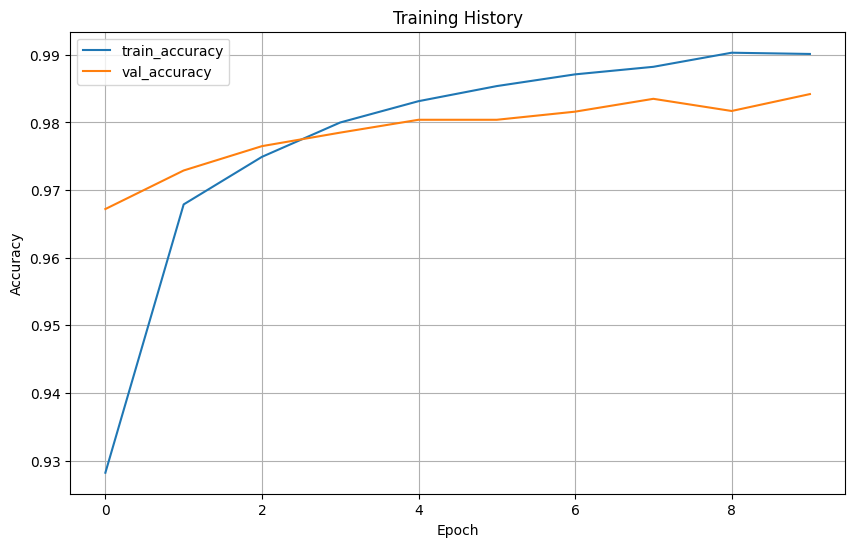

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history['train_acc'], label='train_accuracy')
plt.plot(history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

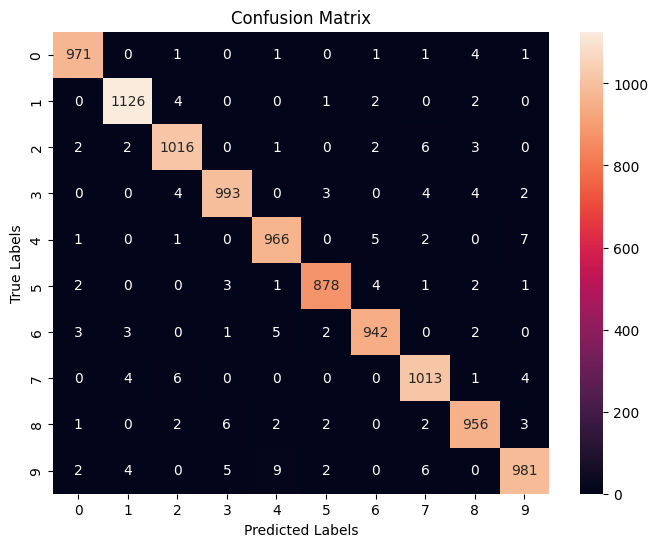

In [ ]:
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

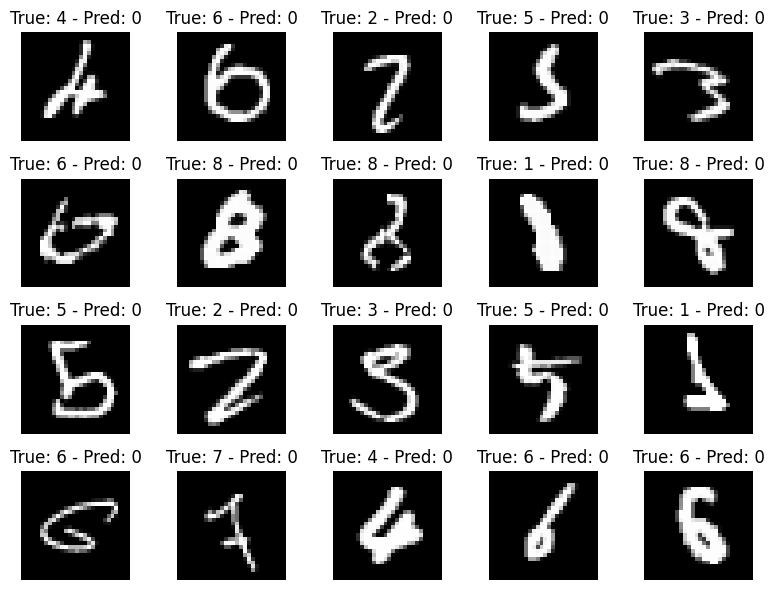

In [ ]:
incorrect_indices = np.where(targets != predictions)[0]

plt.figure(figsize=(8, 6))
for i, idx in enumerate(incorrect_indices[:20]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"True: {np.argmax(y_test[idx])} - Pred: {np.argmax(predictions[idx])}")
    plt.axis('off')
plt.tight_layout()
plt.show()